# Part I: Building a Basic NN

#### Importing libraries:

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torchvision import datasets

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.backends.mps.is_available()

True

### Step 1: Loading the Dataset

In [3]:
df = pd.read_csv('/Users/rohitambati/Desktop/Masters/Spring 2023/ML/Assignment 2/dataset.csv')
df

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1
...,...,...,...,...,...,...,...,...
761,9,89,62,0,0,22.5,e,0
762,10,101,76,48,180,d,0.171,0
763,2,122,70,27,b,36.8,0.34,0
764,c,121,72,23,112,26.2,0.245,0


In [4]:
df.shape

(766, 8)

### Step 2: Preprocessing the Dataset

Removing all rows from the dataset that have a non-numeric value. For example, removing row 764 from df it has a non-numeric value, i.e., 'c'.

In [5]:
# for col in list(df.columns):
#   print(df[col].unique())

In [6]:
for col in list(df.columns):
    x = df[col].unique()
    non_numeric_element = ""
    for element in x:
        try:
            integer = int(element)
        except: 
            non_numeric_element = element
    df = df[df[col] !=  non_numeric_element]

In [7]:
df[['f1']] = df[['f1']].astype(int)
df[['f2']] = df[['f2']].astype(int)
df[['f3']] = df[['f3']].astype(int)
df[['f4']] = df[['f4']].astype(int)
df[['f5']] = df[['f5']].astype(int)
df[['f6']] = df[['f6']].astype(float)
df[['f7']] = df[['f7']].astype(float)

The given dataset consists of 7 feature varibales and a categorical target veriable consisting of two classes 0 and 1. The dataset consists of 766 records. All of the feature varibales consist of numeric data. 

Initially the data read from the csv file was present in the form of a string. After preprocessing and removing irrelavant data from the dataset we get the following below statistics of the dataset. 

In [8]:
df.describe()

,f1,f2,f3,f4,f5,f6,f7,target
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,3.834211,120.969737,69.119737,20.507895,80.234211,31.998684,0.473250,0.350000
std,3.364762,32.023301,19.446088,15.958029,115.581444,7.899724,0.332277,0.477284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.300000,0.243750,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.375500,0.000000
75%,6.000000,141.000000,80.000000,32.000000,128.250000,36.600000,0.627500,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


#### Plot 1: Target Variable Distribution 

We can see from the below graph that the output classes to be predicted are not balanced(i.e., of equal number). Hence we can say that the distribution for training data would be uneven and the model when trained can be slightly biased towards the "Class 0" which has more number of records than the "Class 1" which is nearly half of the number of records of "Class 0"

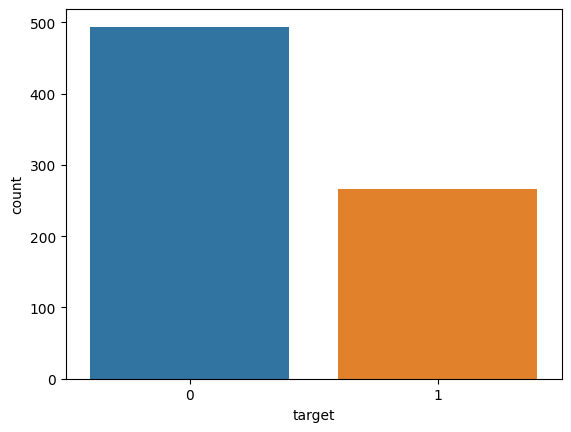

In [9]:
sns.countplot(x ='target', data = df)
plt.show()

#### Plot 2: Pairplot 

1. From the below pairplot graph, we can see the distribution of each feature variable(using histograms) along with the scatter plots that show relation between the feature variables.  
2. We can see that features f2, f3, f4, f6 have their distribution/density graphs close to that of a normal distribution.
3. Feature 1 could be a categorical variable with approximately 17 caategories, or can be considered as a discrete varibale having integer values ranging from 0 to 17.

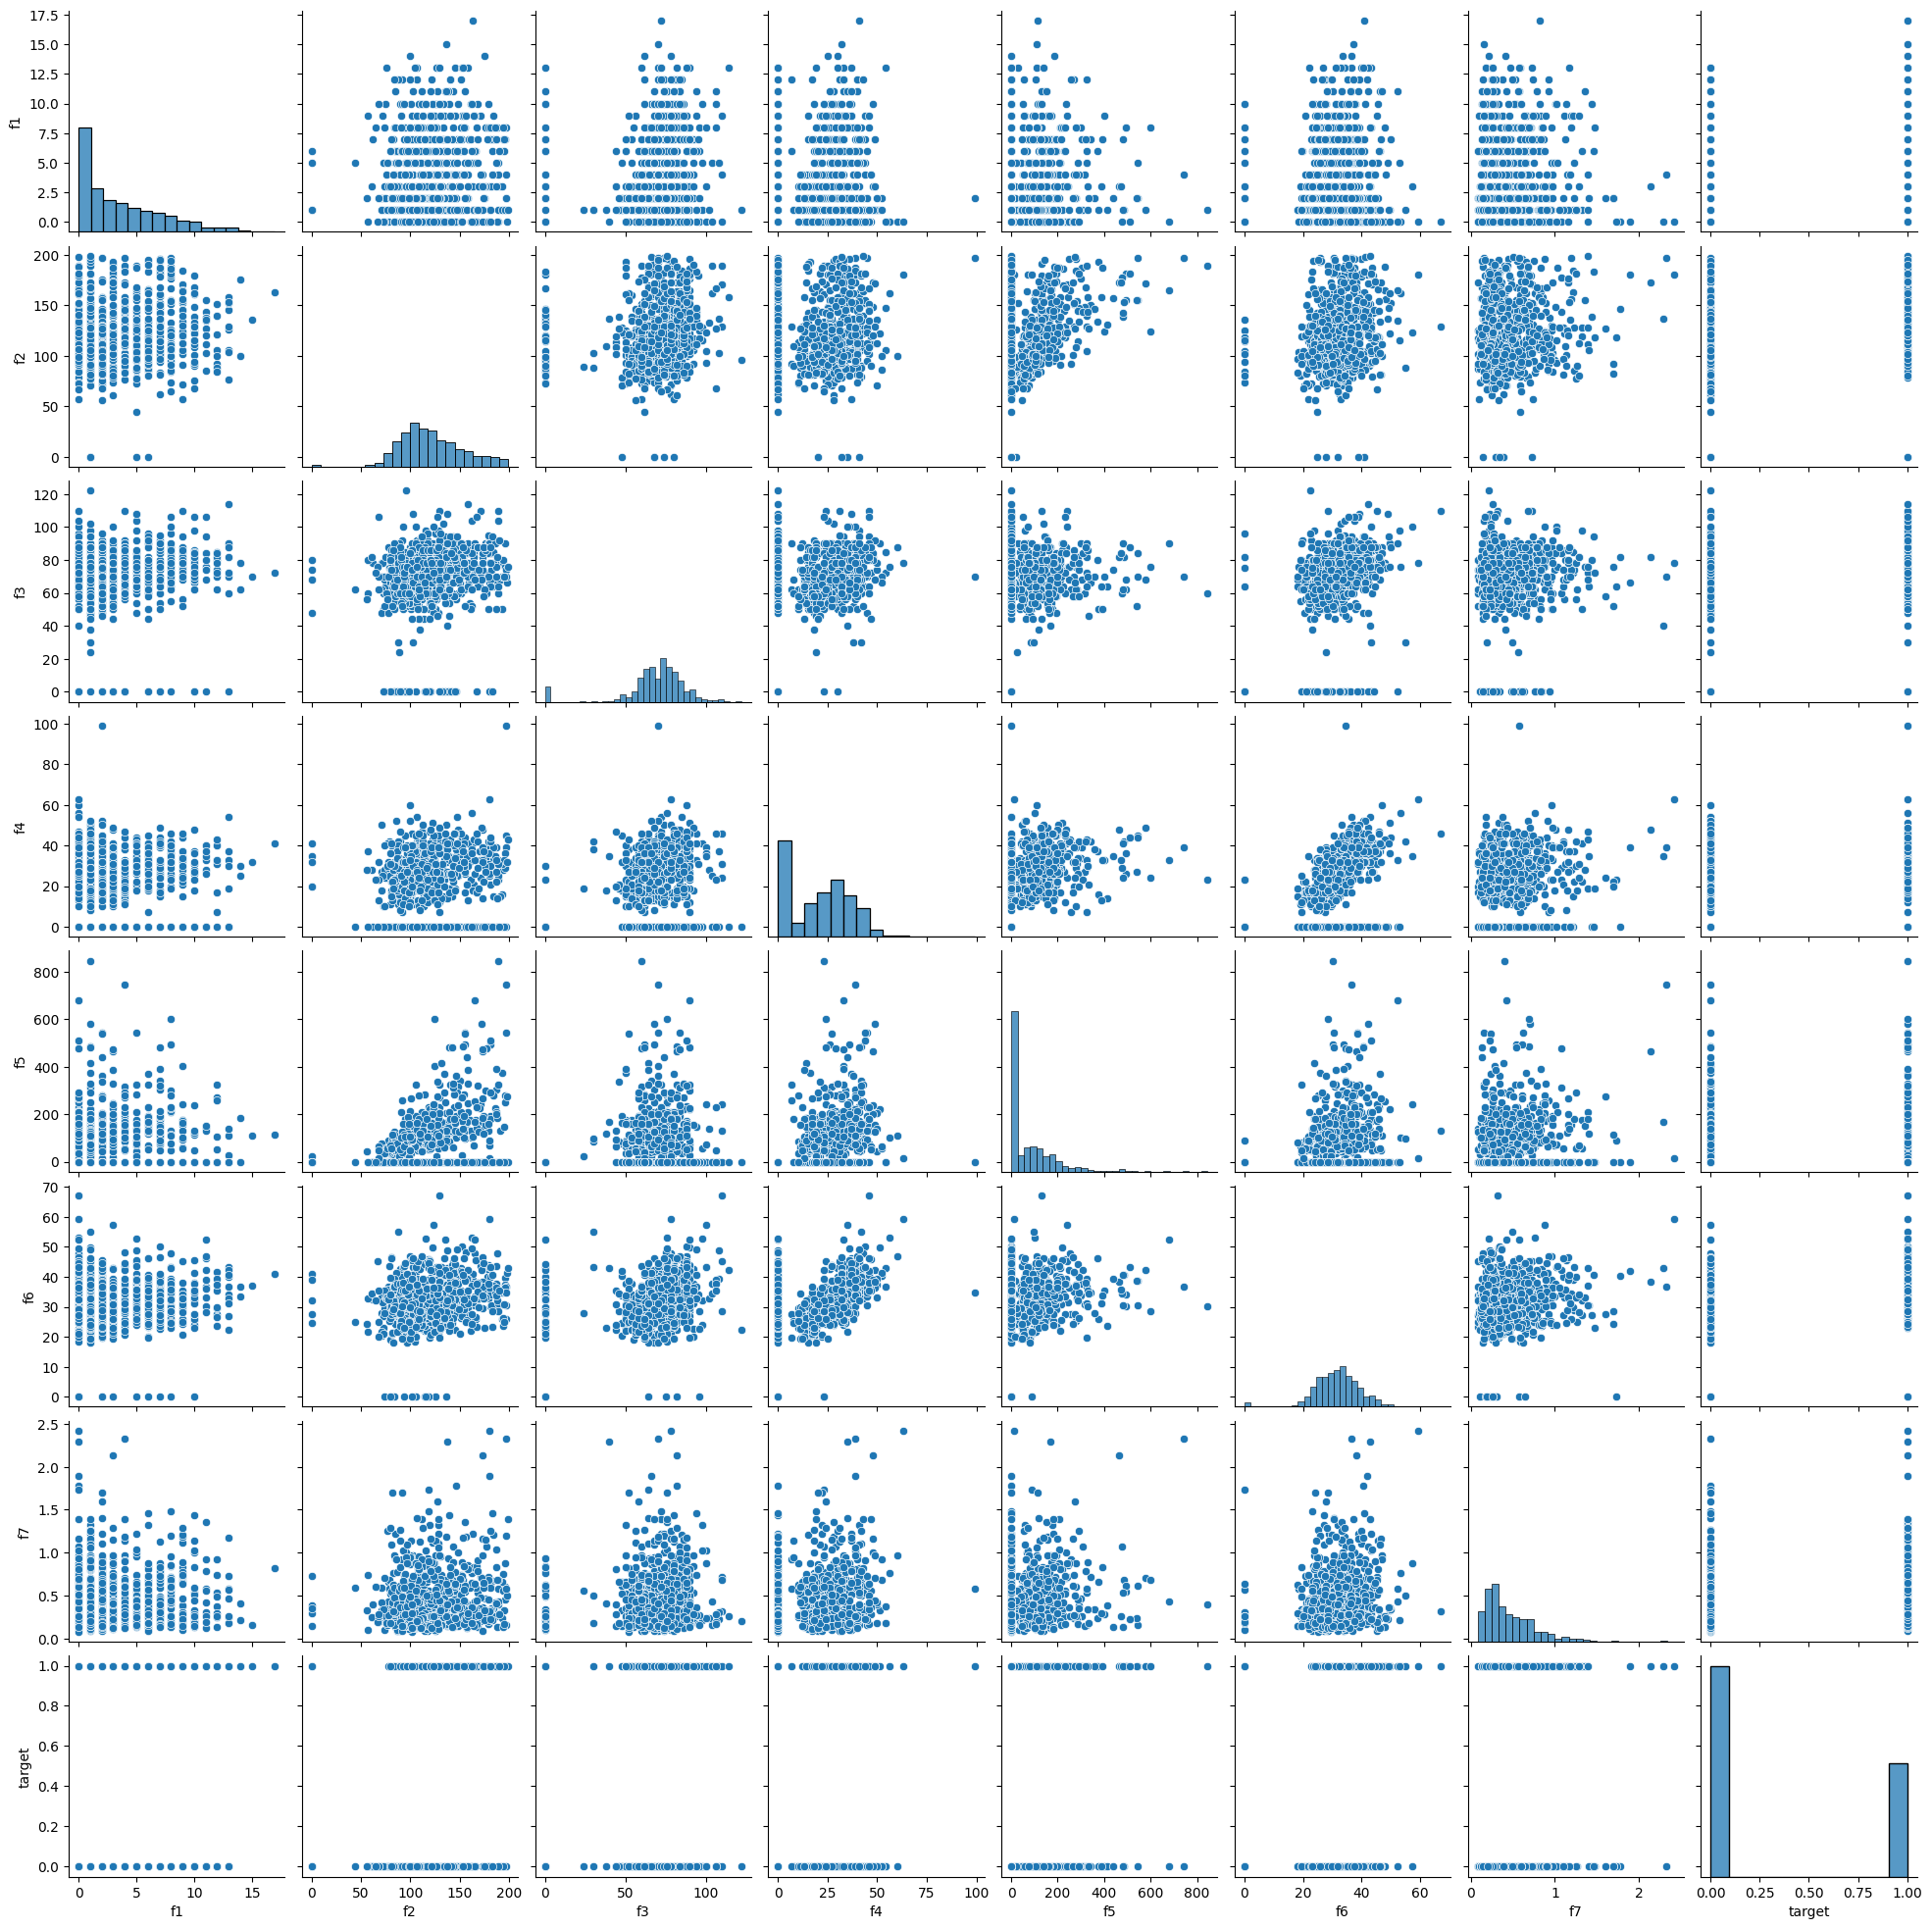

In [15]:
sns.pairplot(df.iloc[:, 0:8])

#### Plot 3: Correlation Plot:

This plot tells us the measure of the extent to which two variables are related. From the below correlation plot, we can observe the following positive correlations: (f2, f5), (f2, f6), (f3,f6), (f4, f6), (f4, f5) (target, f2) and (target, f6). 


In [16]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,f1,f2,f3,f4,f5,f6,f7,target
f1,1.000000,0.129712,0.140772,-0.085733,-0.076051,0.016894,-0.029486,0.224872
f2,0.129712,1.000000,0.151915,0.057686,0.333169,0.217232,0.137290,0.464028
f3,0.140772,0.151915,1.000000,0.206237,0.087869,0.281387,0.042023,0.065462
f4,-0.085733,0.057686,0.206237,1.000000,0.437391,0.391973,0.185557,0.078517
f5,-0.076051,0.333169,0.087869,0.437391,1.000000,0.199214,0.185638,0.132497
f6,0.016894,0.217232,0.281387,0.391973,0.199214,1.000000,0.140369,0.290889
f7,-0.029486,0.137290,0.042023,0.185557,0.185638,0.140369,1.000000,0.173610
target,0.224872,0.464028,0.065462,0.078517,0.132497,0.290889,0.173610,1.000000


In [9]:
y_target = df['target']
X_data = df.drop(['target'], axis = 1)

Split the dataset into train, test and validation sets:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.10)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.20)

#### Feature Scaling:

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Defining Custom Dataloaders:

In [13]:
## Train data
class TrainData:

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy()))

In [14]:
## Test data    
class TestData:
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy()))

In [15]:
## Validation data    
class ValidationData:
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

validation_data = ValidationData(torch.FloatTensor(X_validate.to_numpy()), torch.FloatTensor(y_validate.to_numpy()))

#### Model Parameters:

In [17]:
epochs = 10
batch_size = 64
learning_rate = 0.05

#### Initializing dataloaders:

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)
validation_loader = DataLoader(dataset = validation_data, batch_size = batch_size, shuffle = True)

### Step 3: Defining the Neural Network

In [150]:
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        self.layer_1 = nn.Linear(7, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return x

In [20]:
temp_model = NeuralNetwork1()
print(temp_model)

NeuralNetwork1(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


Input neurons: The input layer should have as many neurons as the number of features in the dataset, which is 7.

Overall, a simple neural network architecture for this problem can be defined as follows:

Input neurons: 7 neurons

Hidden layer 1: 64 neurons with ReLU activation function

Hidden layer 2: 64 input features and 64 output features with ReLU activation function

Output layer: 1 neuron.

#### Accuracy Function:

In [19]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [20]:
def model_accuracy(y_pred_list, y_test):
    count = 0
    test = list(y_test)
    for i in range(len(y_pred_list)):
        if(int(y_pred_list[i]) == test[i]):
            count += 1 
    return(count/len(y_pred_list))

### Step 4: Training the Neural Network

The following steps are performed below to train the neural network:

1. Set up the training loop
2. Define the loss function 
3. Choose an optimizer and a learning rate
4. Train the neural network. 
5. Evaluate the performance of the model on the testing data.
6. Save the weights of the trained neural network.
7. Visualize the results.

In [31]:
def train_loop(model, epochs, train_loader, test_loader, device, criterion, optimizer):
    model.train()
    training_loss = []
    training_accuracy = []
    test_accuracy = []
    test_losses = []
    
    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        training_loss.append(epoch_loss/len(train_loader))  
        training_accuracy.append(epoch_acc/len(train_loader))
        
        y_pred_list, y_true, test_loss = test_loop(model, test_loader, criterion)
        test_accuracy.append(100*model_accuracy(y_pred_list, y_true))
        test_losses.append(test_loss)
        
        print(f'Epoch: {e+0:03} | Train Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f} | Test  Loss: {test_loss:.5f} | Test Acc: {model_accuracy(y_pred_list, y_true):.3f}')
        
    return training_loss, training_accuracy, test_losses, test_accuracy, y_pred_list, y_true

In [22]:
def test_loop(model, test_loader, criterion):
    y_pred_list = []
    y_true = []
    model.eval()
    final_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.extend(y_pred_tag.cpu().numpy())
            y_batch = y_batch.to(device)
            y_true.extend(y_batch.cpu().numpy())
            loss = criterion(y_test_pred, y_batch.unsqueeze(1))
            final_loss = loss.item()
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true =  [a.squeeze().tolist() for a in y_true]
    return y_pred_list, y_true, final_loss/len(test_loader)

In [23]:
def model_accuracy(y_pred_list, y_test):
    #print(y_pred_list)
    count = 0
    test = y_test
    y_pred_list = list(y_pred_list)
    for i in range(len(y_pred_list)):
        #print(y_pred_list[i])
        if(int(y_pred_list[i]) == test[i]):
            count += 1 
    return(count/len(y_pred_list))

In [26]:
#Initializing model
model1 = NeuralNetwork1()
model1.to(device)
print(model1)

# Initializing loss function
epochs = 10
batch_size = 64
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.05

# Initializing optimizer
optimizer = torch.optim.SGD(model1.parameters(), lr = learning_rate, momentum = 0.9)

NeuralNetwork1(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [27]:
training_loss_1, training_accuracy_1, test_loss_1, test_accuracy_1, y_pred_1, y_true_1 = train_loop(model1, epochs, train_loader, test_loader, device, criterion, optimizer)

Epoch: 001 | Train Loss: 0.66749 | Train Acc: 60.333 | Test  Loss: 0.34995 | Test Acc: 0.697
Epoch: 002 | Train Loss: 0.56543 | Train Acc: 70.000 | Test  Loss: 0.32907 | Test Acc: 0.776
Epoch: 003 | Train Loss: 0.49816 | Train Acc: 75.222 | Test  Loss: 0.31360 | Test Acc: 0.816
Epoch: 004 | Train Loss: 0.49047 | Train Acc: 77.222 | Test  Loss: 0.31210 | Test Acc: 0.816
Epoch: 005 | Train Loss: 0.48102 | Train Acc: 77.889 | Test  Loss: 0.31475 | Test Acc: 0.829
Epoch: 006 | Train Loss: 0.47771 | Train Acc: 77.889 | Test  Loss: 0.31527 | Test Acc: 0.829
Epoch: 007 | Train Loss: 0.46470 | Train Acc: 77.889 | Test  Loss: 0.31443 | Test Acc: 0.829
Epoch: 008 | Train Loss: 0.45807 | Train Acc: 78.111 | Test  Loss: 0.31377 | Test Acc: 0.829
Epoch: 009 | Train Loss: 0.45890 | Train Acc: 78.556 | Test  Loss: 0.31169 | Test Acc: 0.829
Epoch: 010 | Train Loss: 0.45305 | Train Acc: 78.444 | Test  Loss: 0.31219 | Test Acc: 0.816


#### Training vs Test Accuracy Plot:

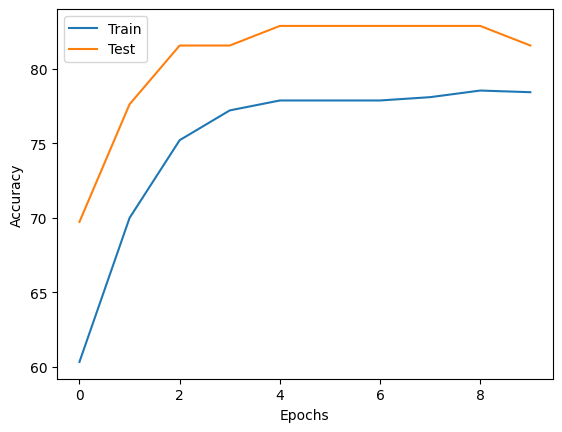

In [28]:
plt.plot(training_accuracy_1, label = 'Train')
plt.plot(test_accuracy_1, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Training vs Test Loss Plot:

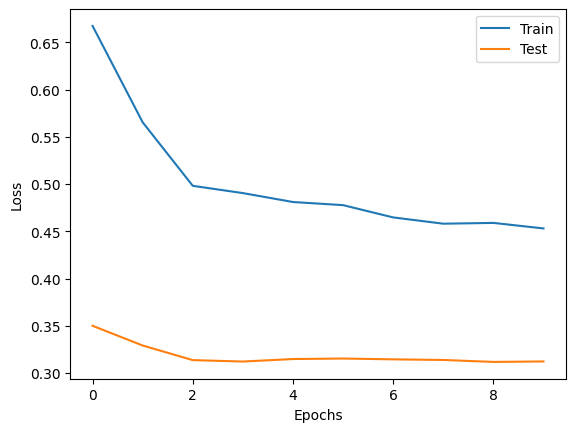

In [29]:
plt.plot(training_loss_1, label = 'Train')
plt.plot(test_loss_1, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [30]:
c_matrix = confusion_matrix(y_true_1, y_pred_1)
c_matrix

array([[48,  4],
       [10, 14]])

#### Classification Report:

In [31]:
print(classification_report(y_true_1, y_pred_1))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87        52
         1.0       0.78      0.58      0.67        24

    accuracy                           0.82        76
   macro avg       0.80      0.75      0.77        76
weighted avg       0.81      0.82      0.81        76



#### Confusion Matrix Plot:

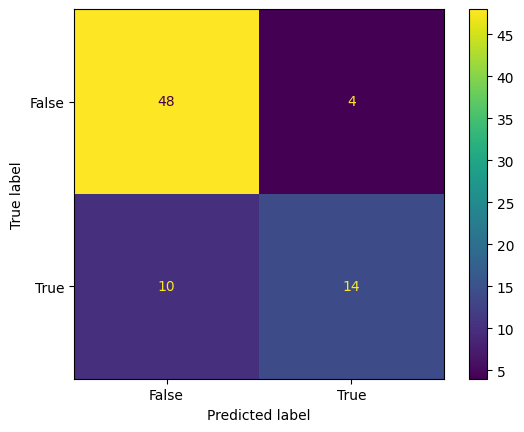

In [32]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

#### Saving the Model:

In [33]:
PATH = "/Users/rohitambati/Desktop/Final_Final_ML/RohitAmbati_LakshmiLikhitha_assignment2_part_1.h5"
torch.save(model1.state_dict(), PATH)

# Part II: Optimizing NN

Based on your NN model defined in Part I, we'll tune the hyperparameters and apply different tools to increase the accuracy. We'll try various setups and draw conclusions.

STEPS: We'll choose one hyperparameter to modify from the following hyperparameters:

1. Dropout
2. Optimizer
3. Activation Function
4. Initializer

Fix the NN structure and all other parameters, and change values only for the chosen hyperparameter.

Changing Dropout:

In [32]:
class OptimizedNeuralNetwork(nn.Module):
    def __init__(self, dropout, activation_function, initializer):
        super(OptimizedNeuralNetwork, self).__init__()
        # Number of input features is 7.
        self.layer_1 = nn.Linear(7, 64)
        if(initializer == 'normal'):
            nn.init.normal_(self.layer_1.weight)
        elif(initializer == 'xavier'):
            nn.init.xavier_uniform_(self.layer_1.weight)
        elif(initializer == 'orthogonal'):
            nn.init.orthogonal_(self.layer_1.weight)
        self.layer_2 = nn.Linear(64, 64)
        if(initializer == 'normal'):
            nn.init.normal_(self.layer_2.weight)
        elif(initializer == 'xavier'):
            nn.init.xavier_uniform_(self.layer_2.weight)
        elif(initializer == 'orthogonal'):
            nn.init.orthogonal_(self.layer_2.weight)  
        self.layer_out = nn.Linear(64, 1) 
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p = dropout)
        #self.batchnorm1 = nn.BatchNorm1d(64)
        #self.batchnorm2 = nn.BatchNorm1d(64)
        
        
    def forward(self, inputs):
        x = self.activation_function(self.layer_1(inputs))
        #x = self.batchnorm1(x)
        x = self.activation_function(self.layer_2(x))
        #x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [33]:
dropout_1 = 0.10
dropout_2 = 0.35
dropout_3 = 0.45 

activation_function_1 = nn.ELU()
activation_function_2 = nn.Tanh()
activation_function_3 = nn.Softplus()
activation_function_relu = nn.ReLU()

initializer_1 = 'normal'
initializer_2 = 'xavier'
initializer_3 = 'orthogonal'

criterion = nn.BCEWithLogitsLoss()

### MODEL 1 : Dropout = 0.10, Activation Function = ELU, Initializer = Normal, Optimizer = ADAM

In [34]:
epochs = 20

onn_1 = OptimizedNeuralNetwork(dropout = dropout_1, activation_function = activation_function_1, initializer = initializer_1)
onn_1.to(device)
print(onn_1)

# Initializing optimizer
onn_1_optimizer = torch.optim.Adam(onn_1.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ELU(alpha=1.0)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [35]:
onn_1_training_loss, onn_1_training_acc, onn_1_test_loss, onn_1_test_accuracy, onn_1_y_pred, onn_1_y_true = train_loop(onn_1, epochs, train_loader, test_loader, device, criterion, onn_1_optimizer)

Epoch: 001 | Train Loss: 2.56637 | Train Acc: 68.889 | Test  Loss: 0.30085 | Test Acc: 0.711
Epoch: 002 | Train Loss: 1.23155 | Train Acc: 67.778 | Test  Loss: 0.35832 | Test Acc: 0.697
Epoch: 003 | Train Loss: 0.72975 | Train Acc: 72.000 | Test  Loss: 0.34444 | Test Acc: 0.724
Epoch: 004 | Train Loss: 0.50002 | Train Acc: 76.667 | Test  Loss: 0.32779 | Test Acc: 0.697
Epoch: 005 | Train Loss: 0.55750 | Train Acc: 78.444 | Test  Loss: 0.35791 | Test Acc: 0.750
Epoch: 006 | Train Loss: 0.48280 | Train Acc: 76.556 | Test  Loss: 0.33937 | Test Acc: 0.724
Epoch: 007 | Train Loss: 0.42632 | Train Acc: 79.333 | Test  Loss: 0.35251 | Test Acc: 0.711
Epoch: 008 | Train Loss: 0.42676 | Train Acc: 80.556 | Test  Loss: 0.34764 | Test Acc: 0.750
Epoch: 009 | Train Loss: 0.40055 | Train Acc: 83.333 | Test  Loss: 0.35775 | Test Acc: 0.684
Epoch: 010 | Train Loss: 0.39964 | Train Acc: 80.889 | Test  Loss: 0.34645 | Test Acc: 0.737
Epoch: 011 | Train Loss: 0.38993 | Train Acc: 81.222 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

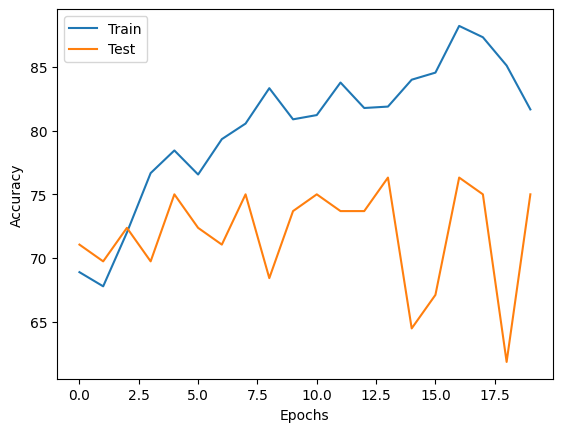

In [36]:
plt.plot(onn_1_training_acc, label = 'Train')
plt.plot(onn_1_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [37]:
onn1_cmatrix = confusion_matrix(onn_1_y_true, onn_1_y_pred)
onn1_cmatrix

array([[46,  5],
       [14, 11]])

#### Classification Report:

In [38]:
print(classification_report(onn_1_y_true, onn_1_y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83        51
         1.0       0.69      0.44      0.54        25

    accuracy                           0.75        76
   macro avg       0.73      0.67      0.68        76
weighted avg       0.74      0.75      0.73        76



#### Confusion Matrix Plot:

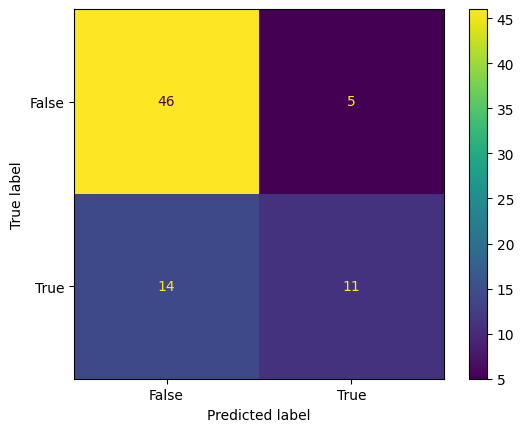

In [39]:
onn1_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn1_cmatrix, display_labels = [False, True])
onn1_cm_display.plot()
plt.show()

### MODEL 2 : Dropout = 0.35, Activation Function = ELU, Initializer = Normal, Optimizer = ADAM

In [46]:
onn_2 = OptimizedNeuralNetwork(dropout = dropout_2, activation_function = activation_function_1, initializer = initializer_1)
onn_2.to(device)
print(onn_2)

# Initializing optimizer
onn_2_optimizer = torch.optim.Adam(onn_2.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ELU(alpha=1.0)
  (dropout): Dropout(p=0.35, inplace=False)
)


In [47]:
onn_2_training_loss, onn_2_training_acc, onn_2_test_loss, onn_2_test_accuracy, onn_2_y_pred_list, onn_2_y_true = train_loop(onn_2, epochs, train_loader, test_loader, device, criterion, onn_2_optimizer)

Epoch: 001 | Train Loss: 1.99107 | Train Acc: 66.556 | Test  Loss: 0.33212 | Test Acc: 0.711
Epoch: 002 | Train Loss: 1.55671 | Train Acc: 65.444 | Test  Loss: 0.40010 | Test Acc: 0.658
Epoch: 003 | Train Loss: 0.74136 | Train Acc: 72.667 | Test  Loss: 0.32207 | Test Acc: 0.750
Epoch: 004 | Train Loss: 0.60590 | Train Acc: 74.444 | Test  Loss: 0.32953 | Test Acc: 0.763
Epoch: 005 | Train Loss: 0.51510 | Train Acc: 77.333 | Test  Loss: 0.32709 | Test Acc: 0.763
Epoch: 006 | Train Loss: 0.46207 | Train Acc: 79.778 | Test  Loss: 0.33662 | Test Acc: 0.724
Epoch: 007 | Train Loss: 0.43256 | Train Acc: 81.778 | Test  Loss: 0.31099 | Test Acc: 0.763
Epoch: 008 | Train Loss: 0.41403 | Train Acc: 81.111 | Test  Loss: 0.33283 | Test Acc: 0.697
Epoch: 009 | Train Loss: 0.40498 | Train Acc: 80.111 | Test  Loss: 0.32012 | Test Acc: 0.737
Epoch: 010 | Train Loss: 0.37368 | Train Acc: 83.333 | Test  Loss: 0.34808 | Test Acc: 0.684
Epoch: 011 | Train Loss: 0.36076 | Train Acc: 81.222 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

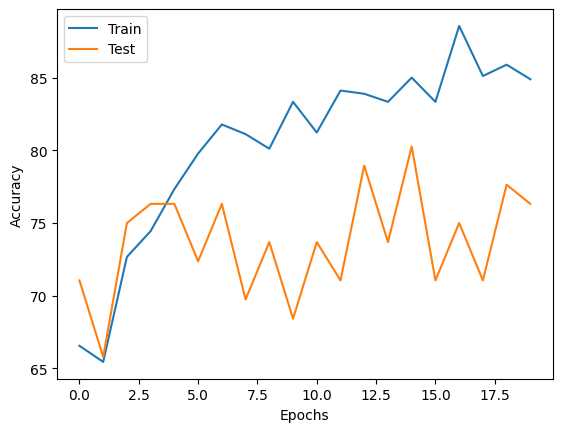

In [48]:
plt.plot(onn_2_training_acc, label = 'Train')
plt.plot(onn_2_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [49]:
onn2_cmatrix = confusion_matrix(onn_2_y_true, onn_2_y_pred_list)
onn2_cmatrix

array([[44,  7],
       [11, 14]])

#### Classification Report:

In [50]:
print(classification_report(onn_2_y_true, onn_2_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83        51
         1.0       0.67      0.56      0.61        25

    accuracy                           0.76        76
   macro avg       0.73      0.71      0.72        76
weighted avg       0.76      0.76      0.76        76



#### Confusion Matrix Plot:

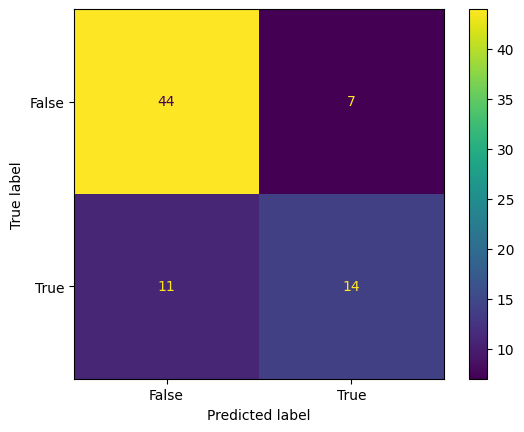

In [51]:
onn2_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn2_cmatrix, display_labels = [False, True])
onn2_cm_display.plot()
plt.show()

### MODEL 3 : Dropout = 0.45, Activation Function = ELU, Initializer = Normal, Optimizer = ADAM

In [54]:
onn_3 = OptimizedNeuralNetwork(dropout = dropout_3, activation_function = activation_function_1, initializer = initializer_1)
onn_3.to(device)
print(onn_3)

# Initializing optimizer
onn_3_optimizer = torch.optim.Adam(onn_3.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ELU(alpha=1.0)
  (dropout): Dropout(p=0.45, inplace=False)
)


In [55]:
onn_3_training_loss, onn_3_training_acc, onn_3_test_loss, onn_3_test_accuracy, onn_3_y_pred_list, onn_3_y_true = train_loop(onn_3, epochs, train_loader, test_loader, device, criterion, onn_3_optimizer)

Epoch: 001 | Train Loss: 2.76819 | Train Acc: 60.556 | Test  Loss: 0.39122 | Test Acc: 0.632
Epoch: 002 | Train Loss: 0.80450 | Train Acc: 72.111 | Test  Loss: 0.38386 | Test Acc: 0.618
Epoch: 003 | Train Loss: 0.75827 | Train Acc: 73.778 | Test  Loss: 0.34802 | Test Acc: 0.737
Epoch: 004 | Train Loss: 0.55346 | Train Acc: 74.000 | Test  Loss: 0.34267 | Test Acc: 0.724
Epoch: 005 | Train Loss: 0.50287 | Train Acc: 76.556 | Test  Loss: 0.34106 | Test Acc: 0.684
Epoch: 006 | Train Loss: 0.45368 | Train Acc: 79.889 | Test  Loss: 0.34578 | Test Acc: 0.737
Epoch: 007 | Train Loss: 0.48253 | Train Acc: 76.222 | Test  Loss: 0.35583 | Test Acc: 0.737
Epoch: 008 | Train Loss: 0.40999 | Train Acc: 79.333 | Test  Loss: 0.34657 | Test Acc: 0.711
Epoch: 009 | Train Loss: 0.39845 | Train Acc: 82.333 | Test  Loss: 0.32896 | Test Acc: 0.737
Epoch: 010 | Train Loss: 0.44396 | Train Acc: 78.222 | Test  Loss: 0.36193 | Test Acc: 0.711
Epoch: 011 | Train Loss: 0.37698 | Train Acc: 82.111 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

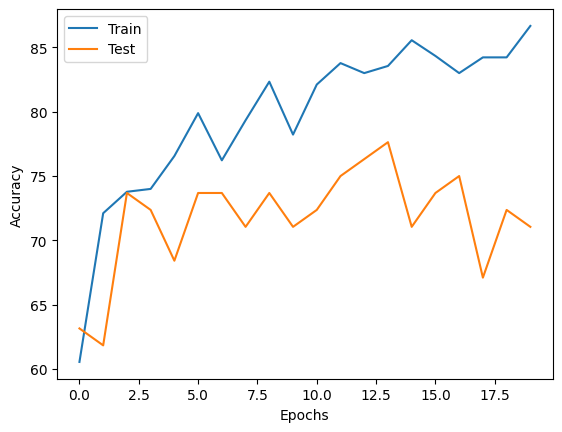

In [56]:
plt.plot(onn_3_training_acc, label = 'Train')
plt.plot(onn_3_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [57]:
onn3_cmatrix = confusion_matrix(onn_3_y_true, onn_3_y_pred_list)
onn3_cmatrix

array([[46,  5],
       [17,  8]])

#### Classification Report:

In [58]:
print(classification_report(onn_3_y_true, onn_3_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.73      0.90      0.81        51
         1.0       0.62      0.32      0.42        25

    accuracy                           0.71        76
   macro avg       0.67      0.61      0.61        76
weighted avg       0.69      0.71      0.68        76



#### Confusion Matrix Plot:

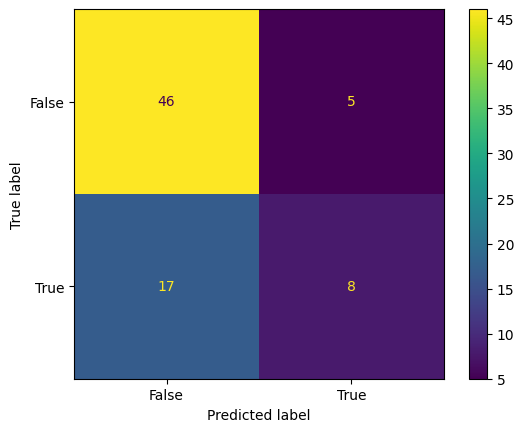

In [59]:
onn3_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn3_cmatrix, display_labels = [False, True])
onn3_cm_display.plot()
plt.show()

### MODEL 4 : Dropout = 0.10, Activation Function = Tanh, Initializer = Normal, Optimizer = ADAM

In [61]:
onn_4 = OptimizedNeuralNetwork(dropout = dropout_1, activation_function = activation_function_2, initializer = initializer_1)
onn_4.to(device)
print(onn_4)

# Initializing optimizer
onn_4_optimizer = torch.optim.Adam(onn_4.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [62]:
onn_4_training_loss, onn_4_training_acc, onn_4_test_loss, onn_4_test_accuracy, onn_4_y_pred_list, onn_4_y_true = train_loop(onn_4, epochs, train_loader, test_loader, device, criterion, onn_4_optimizer)

Epoch: 001 | Train Loss: 0.61297 | Train Acc: 67.556 | Test  Loss: 0.37011 | Test Acc: 0.632
Epoch: 002 | Train Loss: 0.46918 | Train Acc: 78.889 | Test  Loss: 0.34705 | Test Acc: 0.724
Epoch: 003 | Train Loss: 0.43403 | Train Acc: 79.222 | Test  Loss: 0.33966 | Test Acc: 0.750
Epoch: 004 | Train Loss: 0.36850 | Train Acc: 83.556 | Test  Loss: 0.33337 | Test Acc: 0.763
Epoch: 005 | Train Loss: 0.34441 | Train Acc: 85.222 | Test  Loss: 0.33052 | Test Acc: 0.776
Epoch: 006 | Train Loss: 0.31671 | Train Acc: 86.889 | Test  Loss: 0.32681 | Test Acc: 0.816
Epoch: 007 | Train Loss: 0.27838 | Train Acc: 88.889 | Test  Loss: 0.35568 | Test Acc: 0.711
Epoch: 008 | Train Loss: 0.24541 | Train Acc: 90.111 | Test  Loss: 0.33065 | Test Acc: 0.776
Epoch: 009 | Train Loss: 0.22762 | Train Acc: 90.889 | Test  Loss: 0.34362 | Test Acc: 0.724
Epoch: 010 | Train Loss: 0.22427 | Train Acc: 91.778 | Test  Loss: 0.32870 | Test Acc: 0.750
Epoch: 011 | Train Loss: 0.16936 | Train Acc: 94.667 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

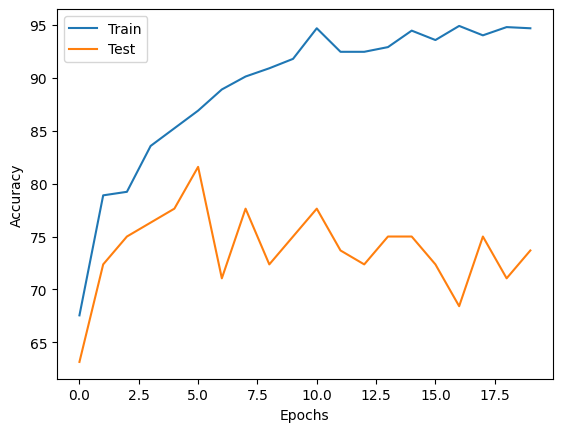

In [63]:
plt.plot(onn_4_training_acc, label = 'Train')
plt.plot(onn_4_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [64]:
onn4_cmatrix = confusion_matrix(onn_4_y_true, onn_4_y_pred_list)
onn4_cmatrix

array([[41, 10],
       [10, 15]])

#### Classification Report:

In [65]:
print(classification_report(onn_4_y_true, onn_4_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        51
         1.0       0.60      0.60      0.60        25

    accuracy                           0.74        76
   macro avg       0.70      0.70      0.70        76
weighted avg       0.74      0.74      0.74        76



#### Confusion Matrix Plot:

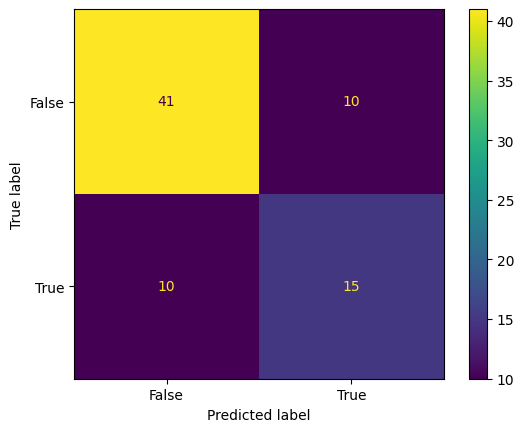

In [66]:
onn4_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn4_cmatrix, display_labels = [False, True])
onn4_cm_display.plot()
plt.show()

### MODEL 5 : Dropout = 0.10, Activation Function = Softplus, Initializer = Normal, Optimizer = ADAM

In [71]:
onn_5 = OptimizedNeuralNetwork(dropout = dropout_1, activation_function = activation_function_3, initializer = initializer_1)
onn_5.to(device)
print(onn_5)

# Initializing optimizer
onn_5_optimizer = torch.optim.Adam(onn_5.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): Softplus(beta=1, threshold=20)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [72]:
onn_5_training_loss, onn_5_training_acc, onn_5_test_loss, onn_5_test_accuracy, onn_5_y_pred_list, onn_5_y_true = train_loop(onn_5, epochs, train_loader, test_loader, device, criterion, onn_5_optimizer)

Epoch: 001 | Train Loss: 3.01573 | Train Acc: 65.889 | Test  Loss: 0.39130 | Test Acc: 0.658
Epoch: 002 | Train Loss: 0.93831 | Train Acc: 66.333 | Test  Loss: 0.33436 | Test Acc: 0.684
Epoch: 003 | Train Loss: 0.53331 | Train Acc: 72.333 | Test  Loss: 0.33292 | Test Acc: 0.737
Epoch: 004 | Train Loss: 0.48962 | Train Acc: 75.778 | Test  Loss: 0.33627 | Test Acc: 0.750
Epoch: 005 | Train Loss: 0.46890 | Train Acc: 78.111 | Test  Loss: 0.34077 | Test Acc: 0.737
Epoch: 006 | Train Loss: 0.44028 | Train Acc: 78.333 | Test  Loss: 0.34303 | Test Acc: 0.750
Epoch: 007 | Train Loss: 0.43596 | Train Acc: 78.333 | Test  Loss: 0.34667 | Test Acc: 0.711
Epoch: 008 | Train Loss: 0.42996 | Train Acc: 78.444 | Test  Loss: 0.34872 | Test Acc: 0.684
Epoch: 009 | Train Loss: 0.42993 | Train Acc: 80.111 | Test  Loss: 0.34558 | Test Acc: 0.711
Epoch: 010 | Train Loss: 0.42537 | Train Acc: 79.333 | Test  Loss: 0.34532 | Test Acc: 0.724
Epoch: 011 | Train Loss: 0.41428 | Train Acc: 80.556 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

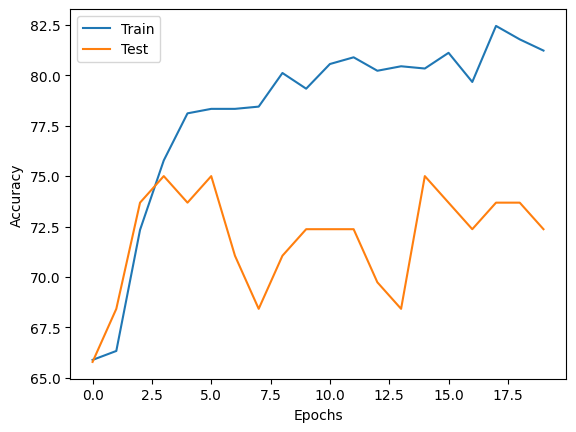

In [73]:
plt.plot(onn_5_training_acc, label = 'Train')
plt.plot(onn_5_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [74]:
onn5_cmatrix = confusion_matrix(onn_5_y_true, onn_5_y_pred_list)
onn5_cmatrix

array([[45,  6],
       [15, 10]])

#### Classification Report:

In [75]:
print(classification_report(onn_5_y_true, onn_5_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81        51
         1.0       0.62      0.40      0.49        25

    accuracy                           0.72        76
   macro avg       0.69      0.64      0.65        76
weighted avg       0.71      0.72      0.70        76



#### Confusion Matrix Plot:

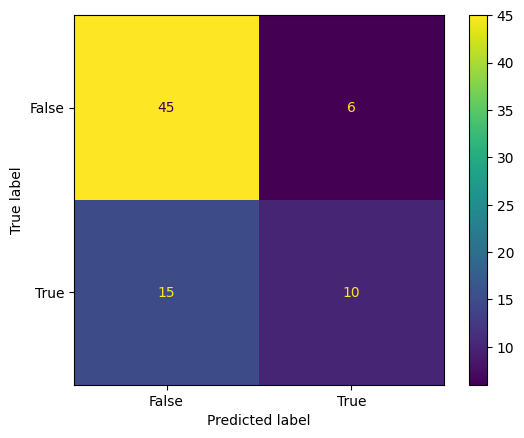

In [76]:
onn5_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn5_cmatrix, display_labels = [False, True])
onn5_cm_display.plot()
plt.show()

### MODEL 6 : Dropout = 0.10, Activation Function = ReLU, Initializer = Xavier, Optimizer = ADAM

In [81]:
onn_6 = OptimizedNeuralNetwork(dropout = dropout_1, activation_function = activation_function_relu, initializer = initializer_2)
onn_6.to(device)
print(onn_6)

# Initializing optimizer
onn_6_optimizer = torch.optim.Adam(onn_6.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [82]:
onn_6_training_loss, onn_6_training_acc, onn_6_test_loss, onn_6_test_accuracy, onn_6_y_pred_list, onn_6_y_true = train_loop(onn_6, epochs, train_loader, test_loader, device, criterion, onn_6_optimizer)

Epoch: 001 | Train Loss: 0.59752 | Train Acc: 67.667 | Test  Loss: 0.34722 | Test Acc: 0.724
Epoch: 002 | Train Loss: 0.50837 | Train Acc: 73.667 | Test  Loss: 0.34100 | Test Acc: 0.776
Epoch: 003 | Train Loss: 0.48528 | Train Acc: 76.889 | Test  Loss: 0.34426 | Test Acc: 0.724
Epoch: 004 | Train Loss: 0.45375 | Train Acc: 78.333 | Test  Loss: 0.34254 | Test Acc: 0.724
Epoch: 005 | Train Loss: 0.45362 | Train Acc: 78.778 | Test  Loss: 0.34403 | Test Acc: 0.737
Epoch: 006 | Train Loss: 0.44337 | Train Acc: 78.556 | Test  Loss: 0.33408 | Test Acc: 0.763
Epoch: 007 | Train Loss: 0.43434 | Train Acc: 79.667 | Test  Loss: 0.34291 | Test Acc: 0.697
Epoch: 008 | Train Loss: 0.43039 | Train Acc: 78.889 | Test  Loss: 0.33211 | Test Acc: 0.711
Epoch: 009 | Train Loss: 0.42772 | Train Acc: 79.556 | Test  Loss: 0.33536 | Test Acc: 0.737
Epoch: 010 | Train Loss: 0.41304 | Train Acc: 79.000 | Test  Loss: 0.34003 | Test Acc: 0.737
Epoch: 011 | Train Loss: 0.39405 | Train Acc: 80.889 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

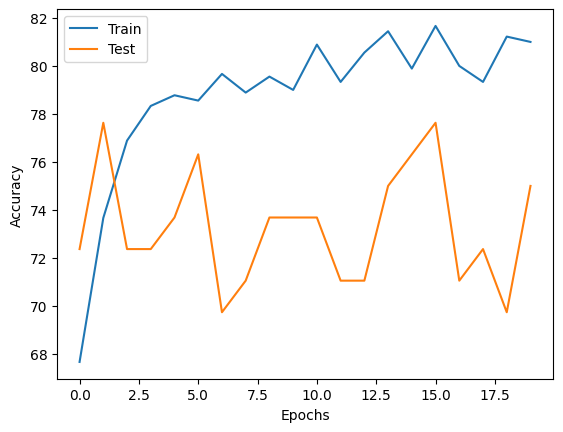

In [83]:
plt.plot(onn_6_training_acc, label = 'Train')
plt.plot(onn_6_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [84]:
onn6_cmatrix = confusion_matrix(onn_6_y_true, onn_6_y_pred_list)
onn6_cmatrix

array([[44,  7],
       [12, 13]])

#### Classification Report:

In [85]:
print(classification_report(onn_6_y_true, onn_6_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82        51
         1.0       0.65      0.52      0.58        25

    accuracy                           0.75        76
   macro avg       0.72      0.69      0.70        76
weighted avg       0.74      0.75      0.74        76



#### Confusion Matrix Plot:

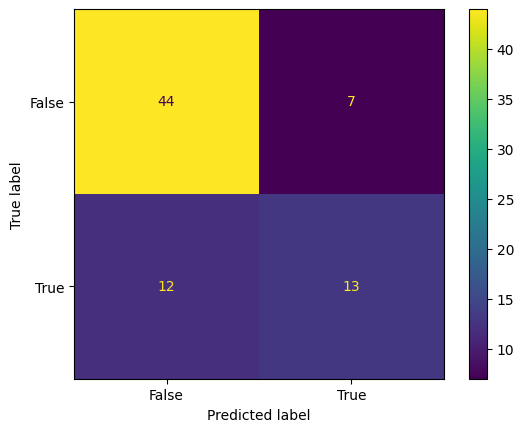

In [86]:
onn6_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn6_cmatrix, display_labels = [False, True])
onn6_cm_display.plot()
plt.show()

### MODEL 7 : Dropout = 0.10, Activation Function = ReLU, Initializer = Orthogonal, Optimizer = ADAM

In [94]:
onn_7 = OptimizedNeuralNetwork(dropout = dropout_1, activation_function = activation_function_relu, initializer = initializer_3)
onn_7.to(device)
print(onn_7)

# Initializing optimizer
onn_7_optimizer = torch.optim.Adam(onn_7.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [95]:
onn_7_training_loss, onn_7_training_acc, onn_7_test_loss, onn_7_test_accuracy, onn_7_y_pred_list, onn_7_y_true = train_loop(onn_7, epochs, train_loader, test_loader, device, criterion, onn_7_optimizer)

Epoch: 001 | Train Loss: 0.57658 | Train Acc: 72.333 | Test  Loss: 0.35248 | Test Acc: 0.711
Epoch: 002 | Train Loss: 0.53270 | Train Acc: 74.556 | Test  Loss: 0.34811 | Test Acc: 0.763
Epoch: 003 | Train Loss: 0.47886 | Train Acc: 76.889 | Test  Loss: 0.35445 | Test Acc: 0.750
Epoch: 004 | Train Loss: 0.46436 | Train Acc: 78.667 | Test  Loss: 0.35158 | Test Acc: 0.750
Epoch: 005 | Train Loss: 0.45763 | Train Acc: 77.444 | Test  Loss: 0.34919 | Test Acc: 0.724
Epoch: 006 | Train Loss: 0.42803 | Train Acc: 79.444 | Test  Loss: 0.34563 | Test Acc: 0.711
Epoch: 007 | Train Loss: 0.41811 | Train Acc: 78.889 | Test  Loss: 0.33929 | Test Acc: 0.737
Epoch: 008 | Train Loss: 0.40983 | Train Acc: 79.889 | Test  Loss: 0.33940 | Test Acc: 0.750
Epoch: 009 | Train Loss: 0.42000 | Train Acc: 80.000 | Test  Loss: 0.33781 | Test Acc: 0.724
Epoch: 010 | Train Loss: 0.40154 | Train Acc: 80.889 | Test  Loss: 0.33442 | Test Acc: 0.763
Epoch: 011 | Train Loss: 0.41957 | Train Acc: 80.444 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

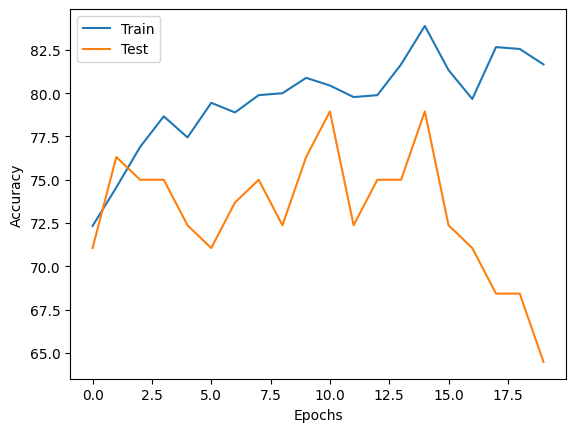

In [96]:
plt.plot(onn_7_training_acc, label = 'Train')
plt.plot(onn_7_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [97]:
onn7_cmatrix = confusion_matrix(onn_7_y_true, onn_7_y_pred_list)
onn7_cmatrix

array([[40, 11],
       [16,  9]])

#### Classification Report:

In [98]:
print(classification_report(onn_7_y_true, onn_7_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.71      0.78      0.75        51
         1.0       0.45      0.36      0.40        25

    accuracy                           0.64        76
   macro avg       0.58      0.57      0.57        76
weighted avg       0.63      0.64      0.63        76



#### Confusion Matrix Plot:

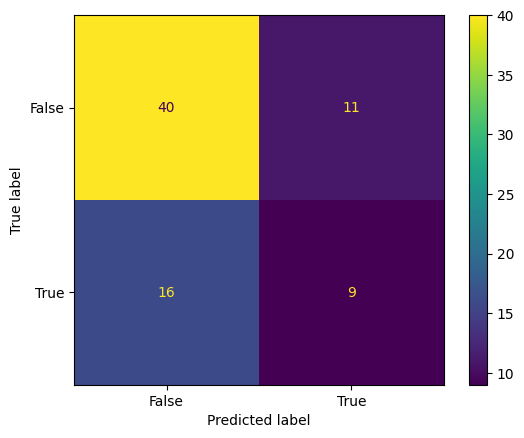

In [99]:
onn7_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn7_cmatrix, display_labels = [False, True])
onn7_cm_display.plot()
plt.show()

### MODEL 8 : Dropout = 0.10, Activation Function = ReLU, Initializer = Normal, Optimizer = ASGD

In [116]:
onn_8 = OptimizedNeuralNetwork(dropout = dropout_1, activation_function = activation_function_relu, initializer = initializer_1)
onn_8.to(device)
print(onn_8)

# Initializing optimizer
onn_8_optimizer = torch.optim.ASGD(onn_8.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [117]:
onn_8_training_loss, onn_8_training_acc, onn_8_test_loss, onn_8_test_accuracy, onn_8_y_pred_list, onn_8_y_true = train_loop(onn_8, epochs, train_loader, test_loader, device, criterion, onn_8_optimizer)

Epoch: 001 | Train Loss: 8.76592 | Train Acc: 59.444 | Test  Loss: 0.34657 | Test Acc: 0.671
Epoch: 002 | Train Loss: 5.77187 | Train Acc: 67.889 | Test  Loss: 0.35437 | Test Acc: 0.763
Epoch: 003 | Train Loss: 4.40075 | Train Acc: 66.333 | Test  Loss: 0.32118 | Test Acc: 0.724
Epoch: 004 | Train Loss: 3.40995 | Train Acc: 71.778 | Test  Loss: 0.32916 | Test Acc: 0.763
Epoch: 005 | Train Loss: 2.70980 | Train Acc: 72.222 | Test  Loss: 0.31336 | Test Acc: 0.711
Epoch: 006 | Train Loss: 1.60104 | Train Acc: 75.111 | Test  Loss: 0.43447 | Test Acc: 0.329
Epoch: 007 | Train Loss: 3.52054 | Train Acc: 66.667 | Test  Loss: 0.34384 | Test Acc: 0.671
Epoch: 008 | Train Loss: 1.83406 | Train Acc: 75.778 | Test  Loss: 0.36261 | Test Acc: 0.632
Epoch: 009 | Train Loss: 2.01758 | Train Acc: 72.111 | Test  Loss: 0.32733 | Test Acc: 0.711
Epoch: 010 | Train Loss: 2.29666 | Train Acc: 70.333 | Test  Loss: 0.36401 | Test Acc: 0.605
Epoch: 011 | Train Loss: 1.85085 | Train Acc: 72.556 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

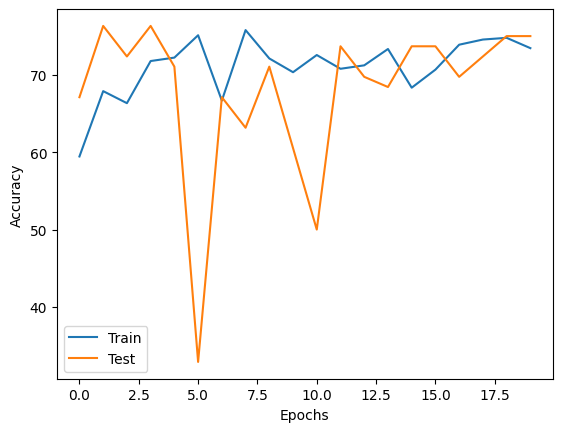

In [118]:
plt.plot(onn_8_training_acc, label = 'Train')
plt.plot(onn_8_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [119]:
onn8_cmatrix = confusion_matrix(onn_8_y_true, onn_8_y_pred_list)
onn8_cmatrix

array([[47,  4],
       [15, 10]])

#### Classification Report:

In [120]:
print(classification_report(onn_8_y_true, onn_8_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83        51
         1.0       0.71      0.40      0.51        25

    accuracy                           0.75        76
   macro avg       0.74      0.66      0.67        76
weighted avg       0.74      0.75      0.73        76



#### Confusion Matrix Plot:

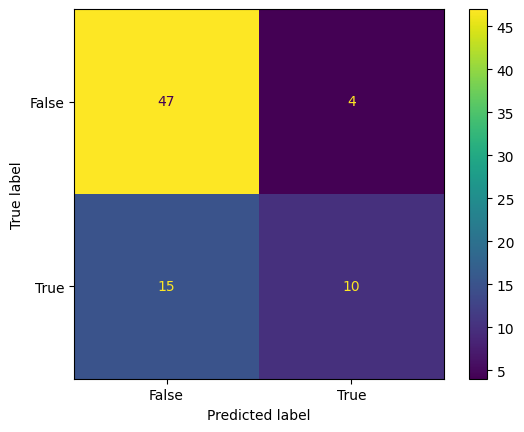

In [121]:
onn8_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn8_cmatrix, display_labels = [False, True])
onn8_cm_display.plot()
plt.show()

### MODEL 9 : Dropout = 0.10, Activation Function = ReLU, Initializer = Normal, Optimizer = Rprop

In [122]:
onn_9 = OptimizedNeuralNetwork(dropout = dropout_1, activation_function = activation_function_relu, initializer = initializer_1)
onn_9.to(device)
print(onn_9)

# Initializing optimizer
onn_9_optimizer = torch.optim.Rprop(onn_9.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [123]:
onn_9_training_loss, onn_9_training_acc, onn_9_test_loss, onn_9_test_accuracy, onn_9_y_pred_list, onn_9_y_true = train_loop(onn_9, epochs, train_loader, test_loader, device, criterion, onn_9_optimizer)

Epoch: 001 | Train Loss: 2.99122 | Train Acc: 62.111 | Test  Loss: 0.31903 | Test Acc: 0.750
Epoch: 002 | Train Loss: 0.62422 | Train Acc: 74.333 | Test  Loss: 0.34173 | Test Acc: 0.671
Epoch: 003 | Train Loss: 0.47697 | Train Acc: 78.889 | Test  Loss: 0.35508 | Test Acc: 0.711
Epoch: 004 | Train Loss: 0.44237 | Train Acc: 80.000 | Test  Loss: 0.34995 | Test Acc: 0.684
Epoch: 005 | Train Loss: 0.43166 | Train Acc: 80.111 | Test  Loss: 0.35113 | Test Acc: 0.684
Epoch: 006 | Train Loss: 0.42962 | Train Acc: 80.333 | Test  Loss: 0.34614 | Test Acc: 0.697
Epoch: 007 | Train Loss: 0.42186 | Train Acc: 79.778 | Test  Loss: 0.35026 | Test Acc: 0.684
Epoch: 008 | Train Loss: 0.42005 | Train Acc: 80.222 | Test  Loss: 0.35032 | Test Acc: 0.684
Epoch: 009 | Train Loss: 0.42764 | Train Acc: 79.556 | Test  Loss: 0.35036 | Test Acc: 0.684
Epoch: 010 | Train Loss: 0.41997 | Train Acc: 80.111 | Test  Loss: 0.35045 | Test Acc: 0.684
Epoch: 011 | Train Loss: 0.41683 | Train Acc: 80.222 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

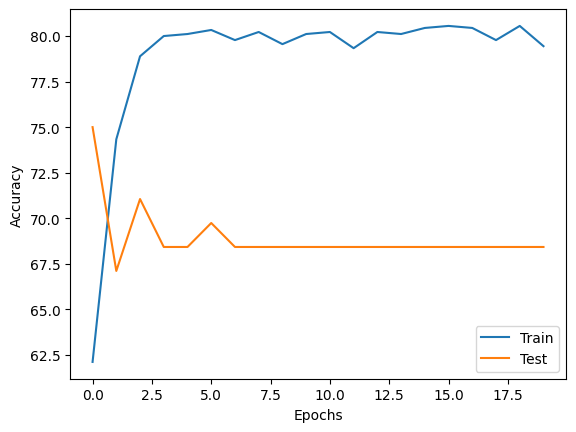

In [124]:
plt.plot(onn_9_training_acc, label = 'Train')
plt.plot(onn_9_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [125]:
onn9_cmatrix = confusion_matrix(onn_9_y_true, onn_9_y_pred_list)
onn9_cmatrix

array([[40, 11],
       [13, 12]])

#### Classification Report:

In [126]:
print(classification_report(onn_9_y_true, onn_9_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77        51
         1.0       0.52      0.48      0.50        25

    accuracy                           0.68        76
   macro avg       0.64      0.63      0.63        76
weighted avg       0.68      0.68      0.68        76



#### Confusion Matrix Plot:

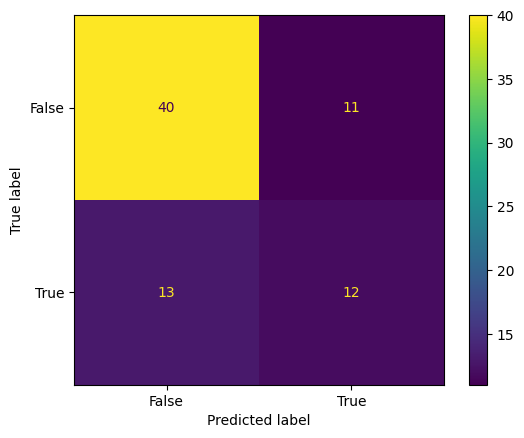

In [127]:
onn9_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn9_cmatrix, display_labels = [False, True])
onn9_cm_display.plot()
plt.show()

### MODEL 10 : Dropout = 0.25, Activation Function = ReLU, Initializer = Normal, Optimizer = SGD

In [128]:
onn_10 = OptimizedNeuralNetwork(dropout = 0.25, activation_function = activation_function_relu, initializer = initializer_1)
onn_10.to(device)
print(onn_10)

# Initializing optimizer
onn_10_optimizer = torch.optim.SGD(onn_10.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [129]:
onn_10_training_loss, onn_10_training_acc, onn_10_test_loss, onn_10_test_accuracy, onn_10_y_pred_list, onn_10_y_true = train_loop(onn_10, epochs, train_loader, test_loader, device, criterion, onn_10_optimizer)

Epoch: 001 | Train Loss: 6.57195 | Train Acc: 64.222 | Test  Loss: 0.41589 | Test Acc: 0.526
Epoch: 002 | Train Loss: 6.36795 | Train Acc: 63.222 | Test  Loss: 0.29785 | Test Acc: 0.671
Epoch: 003 | Train Loss: 5.12019 | Train Acc: 66.444 | Test  Loss: 0.31173 | Test Acc: 0.684
Epoch: 004 | Train Loss: 2.26747 | Train Acc: 70.556 | Test  Loss: 0.39526 | Test Acc: 0.592
Epoch: 005 | Train Loss: 4.11454 | Train Acc: 65.333 | Test  Loss: 0.37745 | Test Acc: 0.592
Epoch: 006 | Train Loss: 1.92854 | Train Acc: 73.111 | Test  Loss: 0.35561 | Test Acc: 0.697
Epoch: 007 | Train Loss: 1.93674 | Train Acc: 70.000 | Test  Loss: 0.32890 | Test Acc: 0.711
Epoch: 008 | Train Loss: 2.15460 | Train Acc: 68.778 | Test  Loss: 0.33821 | Test Acc: 0.724
Epoch: 009 | Train Loss: 1.94214 | Train Acc: 72.556 | Test  Loss: 0.32498 | Test Acc: 0.684
Epoch: 010 | Train Loss: 2.04693 | Train Acc: 69.778 | Test  Loss: 0.30429 | Test Acc: 0.763
Epoch: 011 | Train Loss: 1.62825 | Train Acc: 68.889 | Test  Loss: 0.4

#### Training vs Test Accuracy Plot:

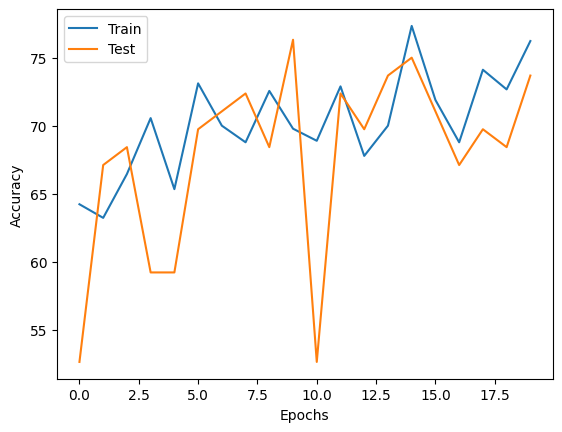

In [130]:
plt.plot(onn_10_training_acc, label = 'Train')
plt.plot(onn_10_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [131]:
onn10_cmatrix = confusion_matrix(onn_10_y_true, onn_10_y_pred_list)
onn10_cmatrix

array([[46,  5],
       [15, 10]])

#### Classification Report:

In [132]:
print(classification_report(onn_10_y_true, onn_10_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        51
         1.0       0.67      0.40      0.50        25

    accuracy                           0.74        76
   macro avg       0.71      0.65      0.66        76
weighted avg       0.73      0.74      0.72        76



#### Confusion Matrix Plot:

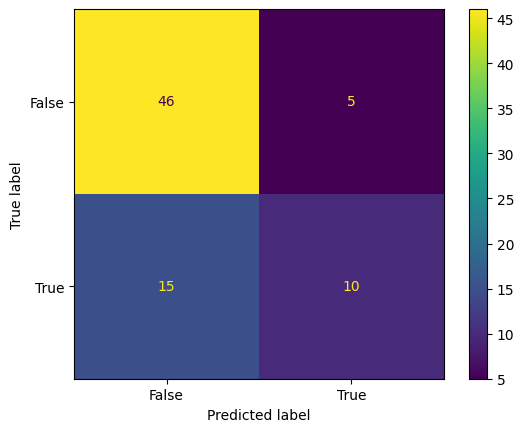

In [133]:
onn10_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn10_cmatrix, display_labels = [False, True])
onn10_cm_display.plot()
plt.show()

### MODEL 11 : Dropout = 0.25, Activation Function = ReLU, Initializer = Xavier, Optimizer = SGD

In [134]:
onn_11 = OptimizedNeuralNetwork(dropout = 0.25, activation_function = activation_function_relu, initializer = initializer_2)
onn_11.to(device)
print(onn_11)

# Initializing optimizer
onn_11_optimizer = torch.optim.SGD(onn_11.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [135]:
onn_11_training_loss, onn_11_training_acc, onn_11_test_loss, onn_11_test_accuracy, onn_11_y_pred_list, onn_11_y_true = train_loop(onn_11, epochs, train_loader, test_loader, device, criterion, onn_11_optimizer)

Epoch: 001 | Train Loss: 0.67254 | Train Acc: 63.778 | Test  Loss: 0.37953 | Test Acc: 0.697
Epoch: 002 | Train Loss: 0.64259 | Train Acc: 68.444 | Test  Loss: 0.37529 | Test Acc: 0.711
Epoch: 003 | Train Loss: 0.62475 | Train Acc: 66.778 | Test  Loss: 0.37237 | Test Acc: 0.711
Epoch: 004 | Train Loss: 0.60962 | Train Acc: 67.778 | Test  Loss: 0.36999 | Test Acc: 0.711
Epoch: 005 | Train Loss: 0.59278 | Train Acc: 69.000 | Test  Loss: 0.36775 | Test Acc: 0.711
Epoch: 006 | Train Loss: 0.57914 | Train Acc: 71.889 | Test  Loss: 0.36577 | Test Acc: 0.724
Epoch: 007 | Train Loss: 0.56757 | Train Acc: 71.556 | Test  Loss: 0.36441 | Test Acc: 0.724
Epoch: 008 | Train Loss: 0.55249 | Train Acc: 74.556 | Test  Loss: 0.36267 | Test Acc: 0.724
Epoch: 009 | Train Loss: 0.54301 | Train Acc: 75.333 | Test  Loss: 0.36092 | Test Acc: 0.724
Epoch: 010 | Train Loss: 0.53122 | Train Acc: 76.444 | Test  Loss: 0.35927 | Test Acc: 0.750
Epoch: 011 | Train Loss: 0.52573 | Train Acc: 75.778 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

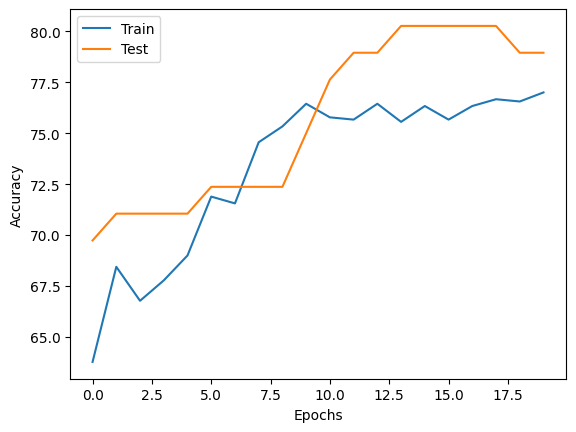

In [136]:
plt.plot(onn_11_training_acc, label = 'Train')
plt.plot(onn_11_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [137]:
onn11_cmatrix = confusion_matrix(onn_11_y_true, onn_11_y_pred_list)
onn11_cmatrix

array([[46,  5],
       [11, 14]])

#### Classification Report:

In [138]:
print(classification_report(onn_11_y_true, onn_11_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85        51
         1.0       0.74      0.56      0.64        25

    accuracy                           0.79        76
   macro avg       0.77      0.73      0.74        76
weighted avg       0.78      0.79      0.78        76



#### Confusion Matrix Plot:

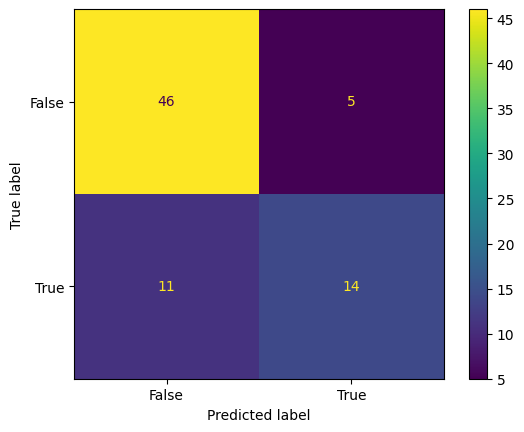

In [139]:
onn11_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn11_cmatrix, display_labels = [False, True])
onn11_cm_display.plot()
plt.show()

### MODEL 12 : Dropout = 0.25, Activation Function = ReLU, Initializer = Orthogonal, Optimizer = SGD

In [142]:
onn_12 = OptimizedNeuralNetwork(dropout = 0.25, activation_function = activation_function_relu, initializer = initializer_3)
onn_12.to(device)
print(onn_12)

# Initializing optimizer
onn_12_optimizer = torch.optim.SGD(onn_12.parameters(), lr = learning_rate)

OptimizedNeuralNetwork(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [143]:
onn_12_training_loss, onn_12_training_acc, onn_12_test_loss, onn_12_test_accuracy, onn_12_y_pred_list, onn_12_y_true = train_loop(onn_12, epochs, train_loader, test_loader, device, criterion, onn_12_optimizer)

Epoch: 001 | Train Loss: 0.69049 | Train Acc: 55.778 | Test  Loss: 0.37772 | Test Acc: 0.658
Epoch: 002 | Train Loss: 0.66976 | Train Acc: 64.556 | Test  Loss: 0.37474 | Test Acc: 0.671
Epoch: 003 | Train Loss: 0.65300 | Train Acc: 64.889 | Test  Loss: 0.37222 | Test Acc: 0.671
Epoch: 004 | Train Loss: 0.63969 | Train Acc: 65.000 | Test  Loss: 0.37006 | Test Acc: 0.671
Epoch: 005 | Train Loss: 0.62945 | Train Acc: 64.889 | Test  Loss: 0.36824 | Test Acc: 0.671
Epoch: 006 | Train Loss: 0.61747 | Train Acc: 65.111 | Test  Loss: 0.36635 | Test Acc: 0.671
Epoch: 007 | Train Loss: 0.60585 | Train Acc: 64.778 | Test  Loss: 0.36466 | Test Acc: 0.684
Epoch: 008 | Train Loss: 0.59573 | Train Acc: 64.889 | Test  Loss: 0.36319 | Test Acc: 0.697
Epoch: 009 | Train Loss: 0.58179 | Train Acc: 68.000 | Test  Loss: 0.36134 | Test Acc: 0.684
Epoch: 010 | Train Loss: 0.57449 | Train Acc: 69.333 | Test  Loss: 0.35981 | Test Acc: 0.697
Epoch: 011 | Train Loss: 0.56394 | Train Acc: 71.222 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

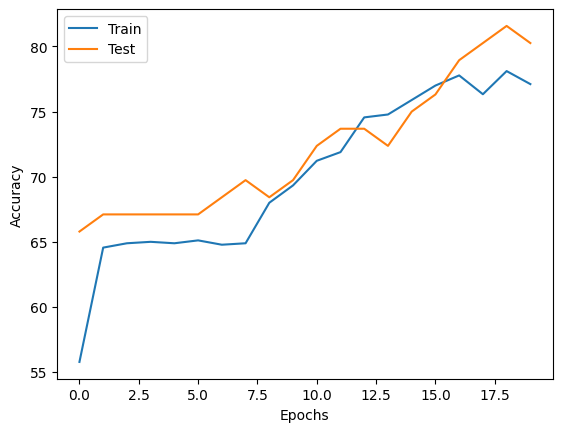

In [144]:
plt.plot(onn_12_training_acc, label = 'Train')
plt.plot(onn_12_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [145]:
onn12_cmatrix = confusion_matrix(onn_12_y_true, onn_12_y_pred_list)
onn12_cmatrix

array([[48,  3],
       [12, 13]])

#### Classification Report:

In [146]:
print(classification_report(onn_12_y_true, onn_12_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86        51
         1.0       0.81      0.52      0.63        25

    accuracy                           0.80        76
   macro avg       0.81      0.73      0.75        76
weighted avg       0.80      0.80      0.79        76



#### Confusion Matrix Plot:

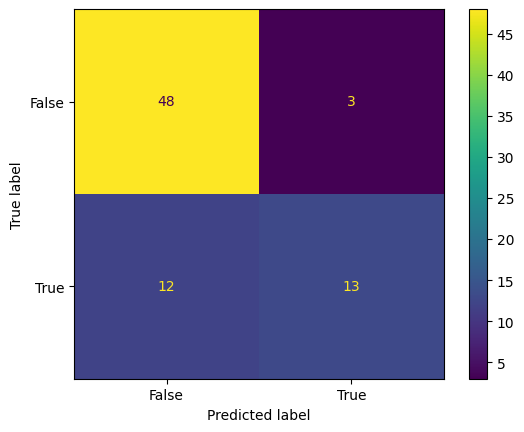

In [147]:
onn12_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = onn12_cmatrix, display_labels = [False, True])
onn12_cm_display.plot()
plt.show()

## 1. Early Stopping:

In [148]:
import numpy as np

In [158]:
#Initializing model
es_model = NeuralNetwork1()
es_model.to(device)
print(es_model)

# Initializing loss function
criterion = nn.BCEWithLogitsLoss()

# Initializing optimizer
es_model_optimizer = torch.optim.SGD(es_model.parameters(), lr = learning_rate, momentum = 0.9)

NeuralNetwork1(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [159]:
def es_train_loop(model, epochs, train_loader, test_loader, val_loader, device, criterion, optimizer):
    
    n_epochs_stop = 5
    min_val_loss = np.Inf
    epochs_no_improve = 0
    final_val_loss = 0
    
    model.train()
    
    training_loss = []
    training_accuracy = []
    test_accuracy = []
    test_losses = []
    
    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        training_loss.append(epoch_loss/len(train_loader))  
        training_accuracy.append(epoch_acc/len(train_loader))
        
        model.eval() 
        y_pred_list, y_true, test_loss = test_loop(model, test_loader, criterion)
        test_accuracy.append(100*model_accuracy(y_pred_list, y_true))
        test_losses.append(test_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for X, y in validation_loader:
                X = X.to(device)
                y = y.to(device)
                outputs = model(X)
                val_loss = criterion(outputs, y.unsqueeze(1))
                final_val_loss += val_loss
                # Average validation loss
                final_val_loss = final_val_loss/len(validation_loader)

                 # If the validation loss is at a minimum
                if final_val_loss < min_val_loss:
                    epochs_no_improve = 0
                    min_val_loss = final_val_loss

                else:
                    #print("final_val_loss:", final_val_loss, "min_val_loss:", min_val_loss)
                    epochs_no_improve += 1
                    # Check early stopping condition
                    if epochs_no_improve == n_epochs_stop:
                        print('Early stopping!')
                        break
        
        print(f'Epoch: {e+0:03} | Train Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f} | Test  Loss: {test_loss:.5f} | Test Acc: {model_accuracy(y_pred_list, y_true):.3f}')
        
    return training_loss, training_accuracy, test_losses, test_accuracy, y_pred_list, y_true

In [160]:
es_training_loss, es_training_acc, es_test_loss, es_test_accuracy, es_y_pred_list, es_y_true = es_train_loop(es_model, 30, train_loader, test_loader, validation_loader, device, criterion, es_model_optimizer)

Epoch: 001 | Train Loss: 0.68229 | Train Acc: 53.667 | Test  Loss: 0.36867 | Test Acc: 0.671
Epoch: 002 | Train Loss: 0.59540 | Train Acc: 65.333 | Test  Loss: 0.35449 | Test Acc: 0.697
Epoch: 003 | Train Loss: 0.53526 | Train Acc: 71.000 | Test  Loss: 0.34812 | Test Acc: 0.776
Epoch: 004 | Train Loss: 0.49634 | Train Acc: 75.556 | Test  Loss: 0.34094 | Test Acc: 0.776
Epoch: 005 | Train Loss: 0.47684 | Train Acc: 77.000 | Test  Loss: 0.34150 | Test Acc: 0.776
Epoch: 006 | Train Loss: 0.47834 | Train Acc: 77.889 | Test  Loss: 0.34927 | Test Acc: 0.711
Epoch: 007 | Train Loss: 0.47235 | Train Acc: 78.667 | Test  Loss: 0.34667 | Test Acc: 0.750
Epoch: 008 | Train Loss: 0.46015 | Train Acc: 78.778 | Test  Loss: 0.34704 | Test Acc: 0.737
Epoch: 009 | Train Loss: 0.45468 | Train Acc: 79.000 | Test  Loss: 0.34264 | Test Acc: 0.750
Epoch: 010 | Train Loss: 0.46047 | Train Acc: 79.111 | Test  Loss: 0.34142 | Test Acc: 0.737
Epoch: 011 | Train Loss: 0.44365 | Train Acc: 79.556 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

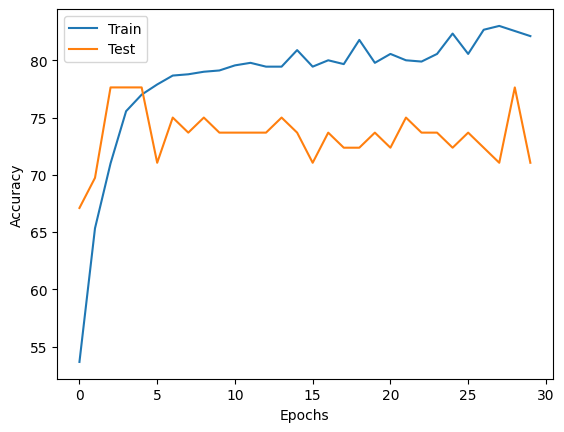

In [163]:
plt.plot(es_training_acc, label = 'Train')
plt.plot(es_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [164]:
es_cmatrix = confusion_matrix(es_y_true, es_y_pred_list)
es_cmatrix

array([[44,  7],
       [15, 10]])

#### Classification Report:

In [165]:
print(classification_report(es_y_true, es_y_pred_list))

              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80        51
         1.0       0.59      0.40      0.48        25

    accuracy                           0.71        76
   macro avg       0.67      0.63      0.64        76
weighted avg       0.69      0.71      0.69        76



#### Confusion Matrix Plot:

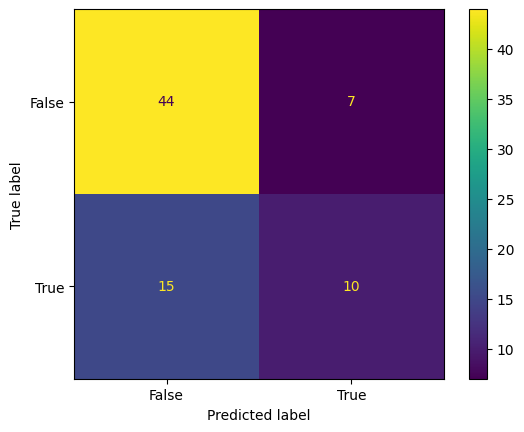

In [166]:
es_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = es_cmatrix, display_labels = [False, True])
es_cm_display.plot()
plt.show()

## 2. K-Fold:

In [167]:
kf = KFold(n_splits = 5, shuffle = True)

# Initializing model
kfold_model = NeuralNetwork1()
kfold_model.to(device)
print(kfold_model)

# Initializing loss function
loss_fn = nn.BCELoss()

# Hyperparameters
learning_rate = 0.01
batch_size = 64

# Initializing optimizer
kfold_model_optimizer = torch.optim.SGD(kfold_model.parameters(), lr = learning_rate, momentum = 0.9)


NeuralNetwork1(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [168]:
X = torch.tensor(X_data.values, dtype = torch.float32)
y = torch.tensor(y_target.values, dtype = torch.float32)

In [169]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.backends.mps.is_available()

True

Fold 1
NeuralNetwork1(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch: 001 | Train Loss: 5.42316 | Train Acc: 61.600 | Test  Loss: 0.30114 | Test Acc: 0.454
Epoch: 002 | Train Loss: 0.71316 | Train Acc: 60.500 | Test  Loss: 0.28340 | Test Acc: 0.684
Epoch: 003 | Train Loss: 0.67332 | Train Acc: 64.000 | Test  Loss: 0.26470 | Test Acc: 0.678
Epoch: 004 | Train Loss: 0.63943 | Train Acc: 65.400 | Test  Loss: 0.25811 | Test Acc: 0.599
Epoch: 005 | Train Loss: 0.62019 | Train Acc: 69.100 | Test  Loss: 0.26335 | Test Acc: 0.671
Epoch: 006 | Train Loss: 0.61017 | Train Acc: 67.200 | Test  Loss: 0.26134 | Test Acc: 0.671
Epoch: 007 | Train Loss: 0.61498 | Train Acc: 67.800 | Test  Loss: 0.25876 | Test Acc: 0.645
Epoch: 008 | Train Loss: 0.60496 | Train Acc: 69.400 | Test  Loss: 0.26027 | Test Acc: 0.678
Epoch: 009 | Train Los

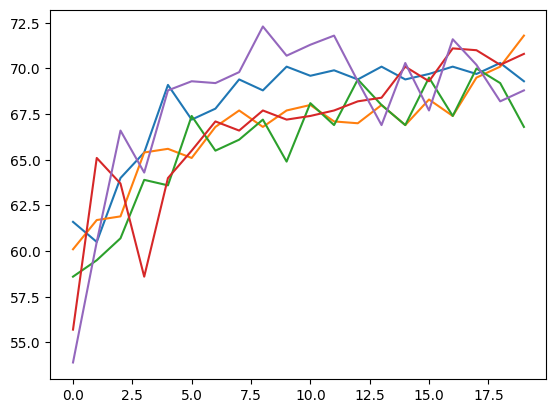

In [174]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    
    kf = KFold(n_splits = 5, shuffle = True)

    # Initializing model
    kfold_model = NeuralNetwork1()
    kfold_model.to(device)
    print(kfold_model)

    # Initializing loss function
    loss_fn = nn.BCELoss()

    # Hyperparameters
    learning_rate = 0.01
    batch_size = 64

    # Initializing optimizer
    kfold_model_optimizer = torch.optim.SGD(kfold_model.parameters(), lr = learning_rate, momentum = 0.9)

    # Split the data into training and validation sets for this fold
    X_train, y_train, X_val, y_val = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    
    # Initialize the dataloaders for this fold
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size = batch_size)
    
    train_loss = []
    kf_training_loss, kf_training_acc, kf_test_loss, kf_test_accuracy, kf_y_pred_list, kf_y_true = train_loop(kfold_model, 20, train_loader, val_loader, device, criterion, kfold_model_optimizer)
    

    print("Done!")
    plt.plot(kf_training_acc)
    
    
    
  

The above plot represents accuracies of different folds of the dataset.

## 3. Batch Normalization:

In [227]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.layer_1 = nn.Linear(7, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout( p = 0.25)
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [228]:
#Initializing model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.backends.mps.is_available()
model2 = NeuralNetwork2()
model2.to(device)
print(model2)

# Initializing loss function
epochs = 20
batch_size = 64
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.05

# Initializing optimizer
model2_optimizer = torch.optim.SGD(model2.parameters(), lr = learning_rate, momentum = 0.9)

NeuralNetwork2(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [229]:
bn_training_loss, bn_training_acc, bn_test_loss, bn_test_accuracy, bn_y_pred_list, bn_y_true = train_loop(model2, epochs, train_loader, test_loader, device, criterion, model2_optimizer)

Epoch: 001 | Train Loss: 0.60349 | Train Acc: 68.200 | Test  Loss: 0.34976 | Test Acc: 0.671
Epoch: 002 | Train Loss: 0.74333 | Train Acc: 64.800 | Test  Loss: 0.38213 | Test Acc: 0.671
Epoch: 003 | Train Loss: 0.60973 | Train Acc: 71.200 | Test  Loss: 0.44270 | Test Acc: 0.329
Epoch: 004 | Train Loss: 0.55454 | Train Acc: 74.100 | Test  Loss: 0.44682 | Test Acc: 0.329
Epoch: 005 | Train Loss: 0.50642 | Train Acc: 75.600 | Test  Loss: 0.44375 | Test Acc: 0.329
Epoch: 006 | Train Loss: 0.50018 | Train Acc: 75.300 | Test  Loss: 0.43925 | Test Acc: 0.329
Epoch: 007 | Train Loss: 0.48968 | Train Acc: 75.700 | Test  Loss: 0.41550 | Test Acc: 0.355
Epoch: 008 | Train Loss: 0.48980 | Train Acc: 75.200 | Test  Loss: 0.40029 | Test Acc: 0.447
Epoch: 009 | Train Loss: 0.47706 | Train Acc: 75.300 | Test  Loss: 0.36373 | Test Acc: 0.671
Epoch: 010 | Train Loss: 0.46827 | Train Acc: 74.900 | Test  Loss: 0.35193 | Test Acc: 0.671
Epoch: 011 | Train Loss: 0.46275 | Train Acc: 76.600 | Test  Loss: 0.3

#### Training vs Test Loss Plot:

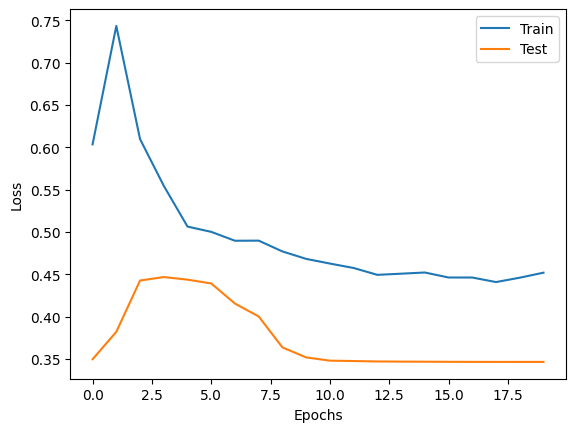

In [231]:
plt.plot(bn_training_loss, label = 'Train')
plt.plot(bn_test_loss, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### 4. Learning Rate Scheduler:

In [237]:
# Initializing model
lrs_model = NeuralNetwork1()
lrs_model.to(device)
print(lrs_model)

# Initializing loss function
criterion = nn.BCEWithLogitsLoss()

# Hyperparameters
learning_rate = 0.01
batch_size = 64

# Initializing optimizer
lrs_optimizer = torch.optim.SGD(lrs_model.parameters(), lr = learning_rate, momentum = 0.9)

NeuralNetwork1(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [238]:
def lrs_train_loop(model, epochs, train_loader, test_loader, device, criterion, optimizer, scheduler):
    model.train()
    training_loss = []
    training_accuracy = []
    test_accuracy = []
    test_losses = []
    
    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))
            
            y_pred_list, y_true, test_loss = test_loop(model, test_loader, criterion)
            scheduler.step(test_loss)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        training_loss.append(epoch_loss/len(train_loader))  
        training_accuracy.append(epoch_acc/len(train_loader))
        
        y_pred_list, y_true, test_loss = test_loop(model, test_loader, criterion)
        test_accuracy.append(100*model_accuracy(y_pred_list, y_true))
        test_losses.append(test_loss)
        
        print(f'Epoch: {e+0:03} | Train Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f} | Test  Loss: {test_loss:.5f} | Test Acc: {model_accuracy(y_pred_list, y_true):.3f}')
        
    return training_loss, training_accuracy, test_losses, test_accuracy, y_pred_list, y_true

In [240]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',patience = 16, factor = 0.3)
lrs_training_loss, lrs_training_acc, lrs_test_loss, lrs_test_accuracy, lrs_y_pred_list, lrs_y_true = lrs_train_loop(lrs_model, epochs, train_loader, test_loader, device, criterion, lrs_optimizer, scheduler)
print("Done!")

Epoch: 001 | Train Loss: 2.66441 | Train Acc: 47.500 | Test  Loss: 0.38027 | Test Acc: 0.658
Epoch: 002 | Train Loss: 0.66537 | Train Acc: 64.200 | Test  Loss: 0.37846 | Test Acc: 0.671
Epoch: 003 | Train Loss: 0.64632 | Train Acc: 66.300 | Test  Loss: 0.37800 | Test Acc: 0.671
Epoch: 004 | Train Loss: 0.64096 | Train Acc: 65.000 | Test  Loss: 0.37683 | Test Acc: 0.671
Epoch: 005 | Train Loss: 0.62932 | Train Acc: 65.200 | Test  Loss: 0.37571 | Test Acc: 0.671
Epoch: 006 | Train Loss: 0.64475 | Train Acc: 64.400 | Test  Loss: 0.37531 | Test Acc: 0.671
Epoch: 007 | Train Loss: 0.61729 | Train Acc: 65.400 | Test  Loss: 0.37424 | Test Acc: 0.671
Epoch: 008 | Train Loss: 0.63472 | Train Acc: 65.600 | Test  Loss: 0.37448 | Test Acc: 0.671
Epoch: 009 | Train Loss: 0.61127 | Train Acc: 66.500 | Test  Loss: 0.37405 | Test Acc: 0.671
Epoch: 010 | Train Loss: 0.61906 | Train Acc: 66.800 | Test  Loss: 0.37380 | Test Acc: 0.671
Epoch: 011 | Train Loss: 0.59746 | Train Acc: 66.100 | Test  Loss: 0.3

#### Training vs Test Accuracy Plot:

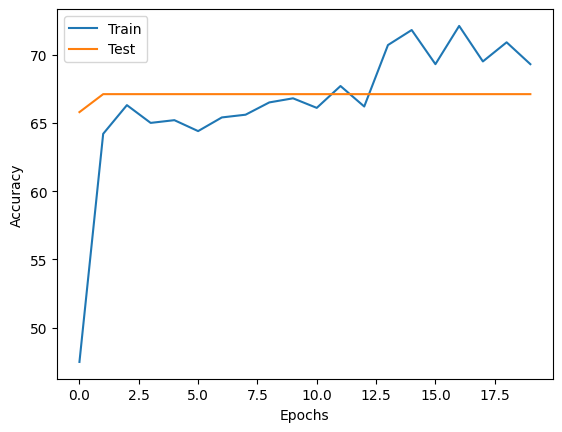

In [242]:
plt.plot(lrs_training_acc, label = 'Train')
plt.plot(lrs_test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Best Model:

In [243]:
PATH = "/Users/rohitambati/Desktop/Final_Final_ML/RohitAmbati_LakshmiLikhitha_assignment2_part_2.h5"
torch.save(onn_12.state_dict(), PATH)

References:
1. https://pytorch.org/docs/stable/index.html
2. https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
3. https://analyticsindiamag.com/step-by-step-guide-to-build-a-simple-neural-network-in-pytorch-from-scratch/
4. https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89
5. https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/